# Fitting a GP

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the kinematic data. Make some cuts to tidy things up. We really only need these kinematic ages for the cool, old stars.

In [3]:
k = pd.read_csv("../data/mcquillan_kinematic_ages.csv")
k_lucy = pd.read_csv("../data/Gyrokinage2020_Prot.csv")
kl = pd.DataFrame(dict({"kepid": k_lucy.kepid.values,
                        "kin_age_lucy": k_lucy.kin_age.values,
                        "kin_age_err": k_lucy.kin_age_err.values}))
k = pd.merge(k, kl, on="kepid", how="left")

# Remove subgiants and photometric binaries
kin = k.iloc[k.flag.values == 1]
finite = np.isfinite(kin.Prot.values) & np.isfinite(kin.bprp_dered.values) & np.isfinite(kin.kin_age_lucy.values)
kin = kin.iloc[finite]

# Remove stars bluer than 1.5 and with kinematic ages greater than 6 as these are likely to be subgiants.
subs = (kin.bprp_dered.values < 1.5) & (kin.kinematic_age.values > 6)
kin = kin.iloc[~subs]

# Remove stars that fall beneath the lower envelope using the Angus + (2019) gyro relation.
no_young = kin.age.values > .7
kin = kin.iloc[no_young]

# Remove stars with kinematic ages greater than 12 as these are likely overestimated.
# not_old = kin.kin_age_lucy.values < 12
# kin = kin.iloc[not_old]

# Remove hot stars as the clusters provide better coverage.
cool = kin.bprp_dered.values > 1.
akin = kin.iloc[cool]
# akin = kin
# akin = akin.iloc[::5]

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


9095


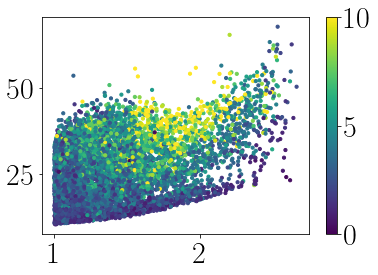

In [4]:
plt.scatter(akin.bprp_dered, akin.Prot, c=akin.kin_age_lucy, s=10, vmin=0, vmax=10)
plt.colorbar()
print(len(akin.Prot))

Now over a grid in period and color, find the median age of points in that range.

In [5]:
from tqdm import trange
dp, dc = .05, .05
logp = np.log10(akin.Prot.values)
pgrid = np.arange(min(logp), max(logp), dp)
cgrid = np.arange(min(akin.bprp_dered.values), max(akin.bprp_dered.values), dc)
P, C = np.meshgrid(pgrid, cgrid)
A = np.zeros_like(P)
prot_errs, npoints = [np.zeros_like(P) for i in range(2)]
for i in range(np.shape(A)[0]):
    for j in range(np.shape(A)[1]):
        b = (logp - .5*dp < P[i, j]) & (P[i, j] < logp + .5*dp)
        b &= (akin.bprp_dered.values - .5*dc < C[i, j]) & (C[i, j] < akin.bprp_dered.values + .5*dc)
        A[i, j] = np.median(akin.kin_age_lucy.values[b])
        prot_errs[i, j] = np.sqrt(sum((akin.Prot_err.values[b]/akin.Prot.values[b])**2)) \
            / np.sqrt(float(len(akin.kin_age_lucy.values[b])))
        npoints[i, j] = len(akin.kin_age_lucy.values[b])

finite = np.isfinite(C) & np.isfinite(P) & np.isfinite(A) & np.isfinite(prot_errs)
morethan = npoints[finite] > 1
C, P, A, prot_errs = C[finite][morethan], P[finite][morethan], A[finite][morethan], prot_errs[finite][morethan]

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


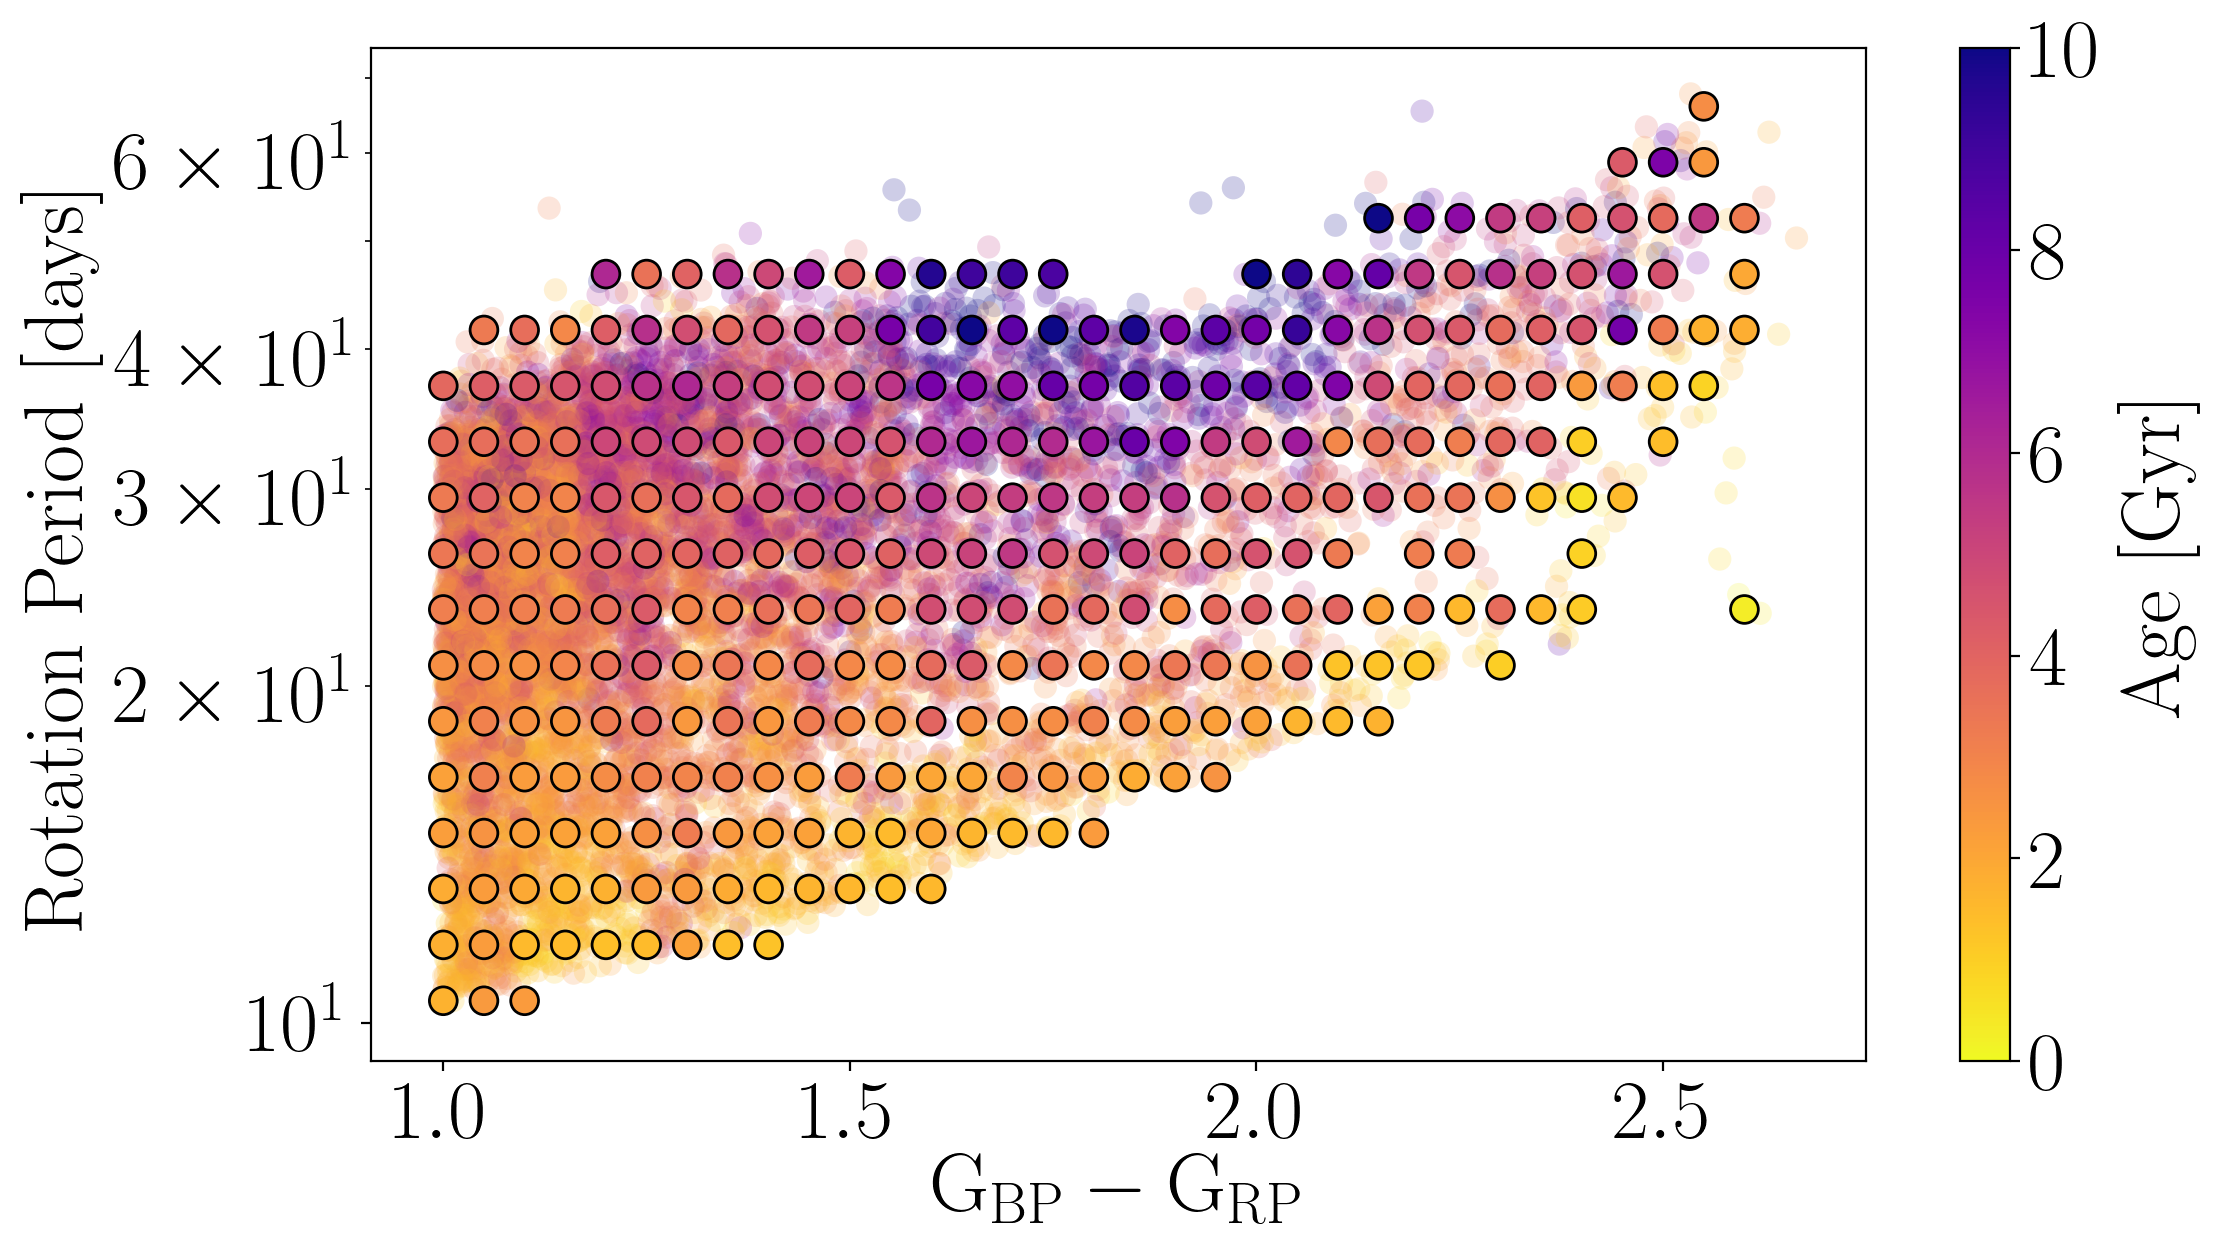

In [6]:
# plt.scatter(akin.bprp_dered, akin.Prot, c=smoothed_ages, s=10, vmin=0, vmax=10)

plotpar = {'axes.labelsize': 30}
plt.rcParams.update(plotpar)

plt.figure(figsize=(12, 7), dpi=200)
plt.scatter(akin.bprp_dered, akin.Prot, c=akin.kin_age_lucy, s=70, vmin=0, vmax=10, alpha=.2, edgecolor="none", cmap="plasma_r")
plt.scatter(np.ndarray.flatten(C), np.ndarray.flatten(10**P), c=np.ndarray.flatten(A), s=100,
            edgecolor="k", vmin=0, vmax=10, cmap="plasma_r")
plt.yscale("log")
plt.colorbar(label="$\mathrm{Age~[Gyr]}$")
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{Rotation~Period~[days]}$");
plt.tight_layout()
plt.savefig("../plots/grid_points")
plt.savefig("../plots/grid_points.pdf")

Format and combine data.

In [7]:
clusters = pd.read_csv("../data/dbf12.csv")

# Do all sorts of cuts on the clusters to remove scatter.
# Remove points that are redder than 1.5 AND have periods shorter than 11 days to get rid of scatter.
ms = (clusters["(BP-RP)0"].values > 1.5) & (clusters.prot.values < 11)

# Remove any rotation periods shorter than 1 day, stars redder than 2.2.
not_fast = (clusters.prot.values[~ms] > 1) & (clusters["(BP-RP)0"].values[~ms] < 2.7) & (clusters["(BP-RP)0"].values[~ms] < 2.2)

# Remove the Pleiades non-converged stars and three outliers.
# no_pleiades = clusters.age_gyr.values[~ms][not_fast] < 0.2
no_pleiades = (clusters.age_gyr.values[~ms][not_fast] <= 0.2) & (clusters["(BP-RP)0"].values[~ms][not_fast] > 1.4)
outliers1 = (clusters.age_gyr.values[~ms][not_fast][~no_pleiades] <= 0.2) \
    & (clusters["(BP-RP)0"].values[~ms][not_fast][~no_pleiades] > .7) \
    & (clusters.prot.values[~ms][not_fast][~no_pleiades] < 2)
outliers2 = (clusters.age_gyr.values[~ms][not_fast][~no_pleiades][~outliers1] <= 0.2) \
    & (clusters["(BP-RP)0"].values[~ms][not_fast][~no_pleiades][~outliers1] < .7) \
    & (clusters.prot.values[~ms][not_fast][~no_pleiades][~outliers1] > 5)

# Apply cuts
cluster_x = clusters["(BP-RP)0"].values[~ms][not_fast][~no_pleiades][~outliers1][~outliers2]
cluster_prot = clusters.prot.values[~ms][not_fast][~no_pleiades][~outliers1][~outliers2]
cluster_age = clusters.age_gyr.values[~ms][not_fast][~no_pleiades][~outliers1][~outliers2]
no_nan = np.isfinite(cluster_x) & np.isfinite(cluster_prot) & np.isfinite(cluster_age) & (cluster_age > 0) & (cluster_prot > 0)
cluster_x, cluster_prot, cluster_age = cluster_x[no_nan], cluster_prot[no_nan], cluster_age[no_nan]

load cluster data with empirical uncertainties calculated from Get_cluster_scatter

In [8]:
cluster_uncert = pd.read_csv("../data/clusters_with_uncertainties.csv")
cluster_x, cluster_prot = cluster_uncert.bprp.values, cluster_uncert.prot.values
cluster_age, cluster_prot_errs = cluster_uncert.age.values, cluster_uncert.prot_err.values 

In [9]:
cluster_old_err = .05
kin_prot_err = np.ndarray.flatten(10**P)*.05
# kin_prot_err = np.ones_like(P)

# Decrease the uncertainties on the oldest clusters to 10%
select_old = cluster_age > 2.
cluster_prot_errs[select_old] = np.ones(len(cluster_prot_errs[select_old])) * cluster_old_err

# Combine clusters with kinematic grid
x = np.concatenate((cluster_x, np.ndarray.flatten(C)))

# Increase uncertainties on kinematic grid to 10%.
prot_err = np.concatenate((cluster_prot_errs, kin_prot_err))  # This works
# this doesn't for some reason.
# prot_err = np.concatenate((cluster_prot_errs, np.ndarray.flatten(prot_errs)))
prot = np.concatenate((cluster_prot, np.ndarray.flatten(10**P)))
age = np.concatenate((cluster_age, np.ndarray.flatten(A)))

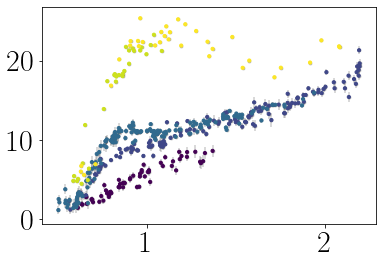

In [10]:
plt.errorbar(cluster_x, cluster_prot, yerr=cluster_prot_errs, fmt="k.", zorder=0, alpha=.2)
plt.scatter(cluster_x, cluster_prot, c=cluster_age, s=10)
# plt.yscale("log")

<ErrorbarContainer object of 3 artists>

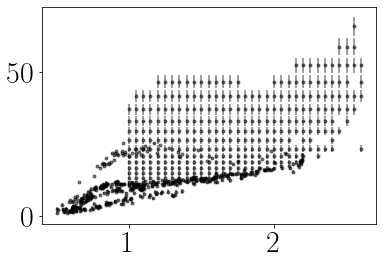

In [11]:
plt.errorbar(x, prot, yerr=prot_err, fmt="k.", alpha=.5)

In [12]:
# Format for GP fit.
inds = np.argsort(x)
x1 = np.array(x[inds])
x2 = np.log(np.array(age[inds]))
y = np.log(np.array(prot[inds]))
y_err = prot_err[inds]/prot[inds]

mu1 = np.mean(x1)
sd1 = np.std(x1)
mu2 = np.mean(x2)
sd2 = np.std(x2)

x2_min = np.min(x2)

xp1 = np.linspace(x1.min() - .2, x1.max() + .2, 1000)
xp2 = np.linspace(x2.min(), x2.max(), 1000)
xg1 = np.linspace(x1.min(), x1.max(), 5)
xg2 = np.linspace(x2.min(), x2.max(), 10)
xg2 = np.array([np.log(.12), np.log(.67), np.log(1), np.log(1.6), np.log(2.7), np.log(4), np.log(5), np.log(8), np.log(10)])
print(np.unique(cluster_age))

[0.12 0.67 1.   2.5  2.7 ]


751 751 751 data points


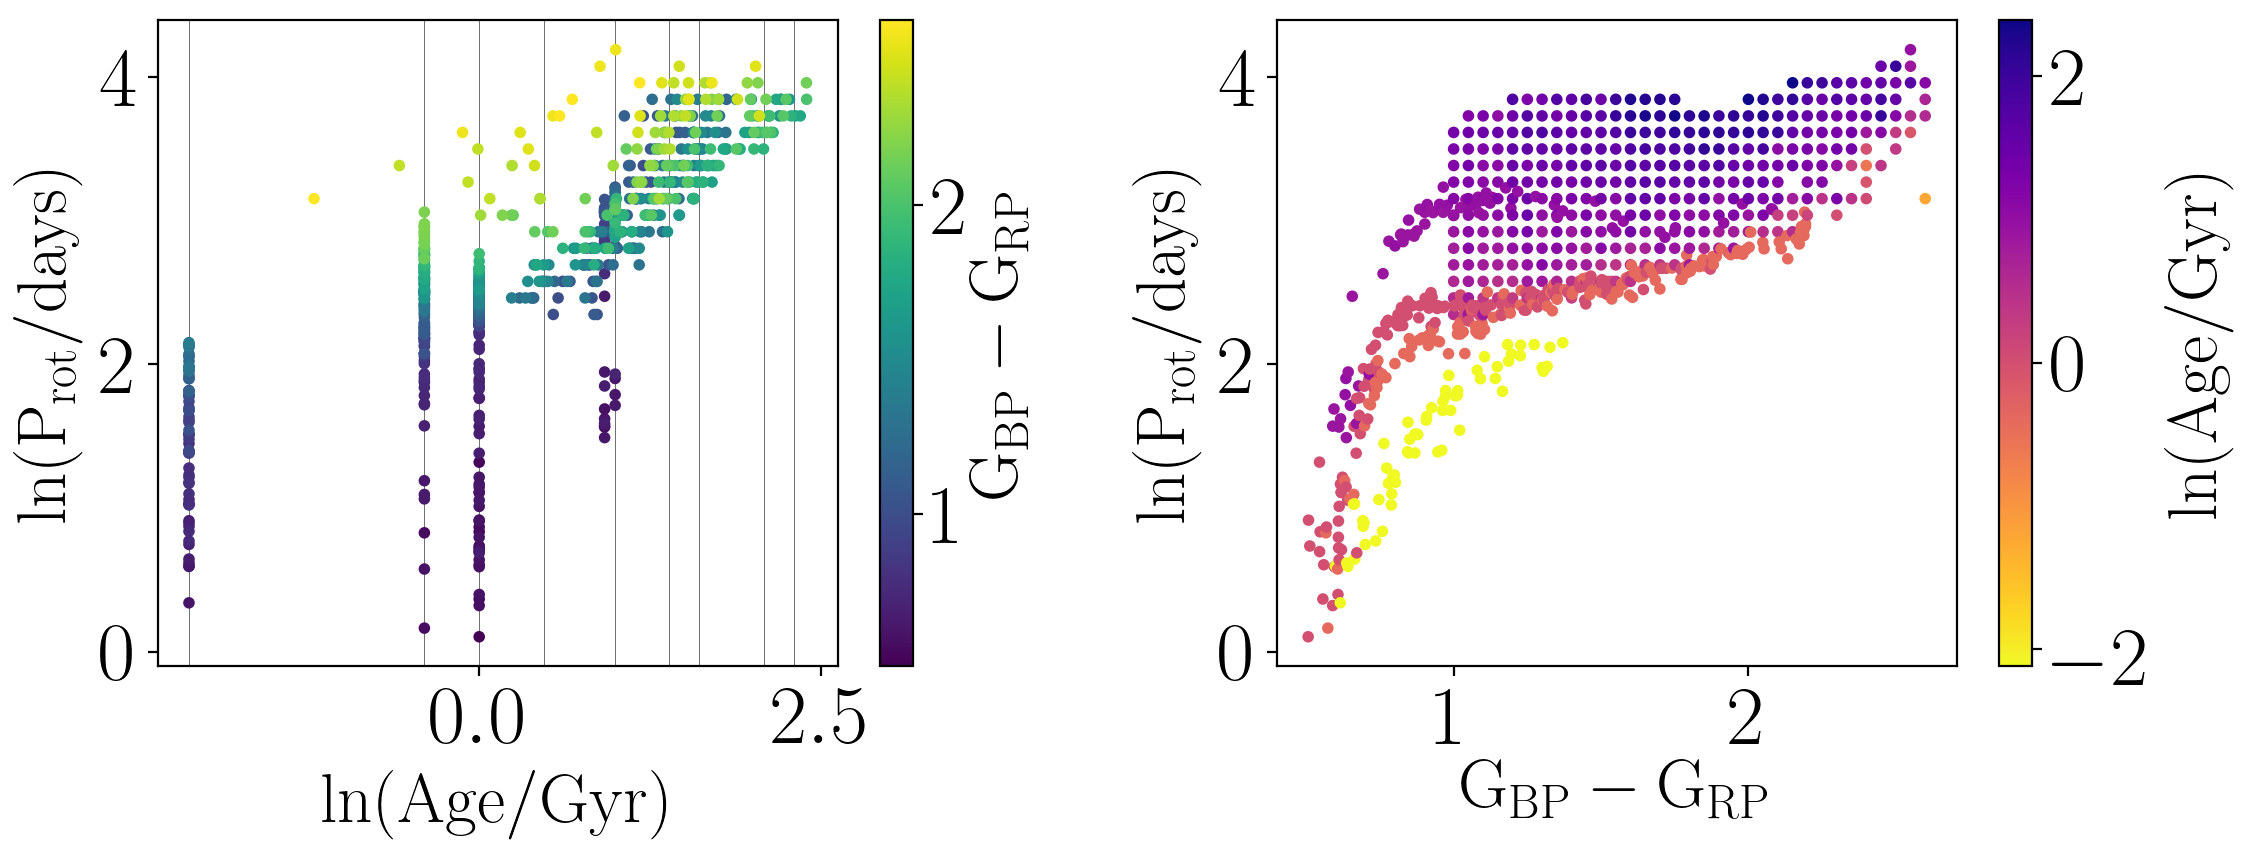

In [13]:
plotpar = {'axes.labelsize': 25}
plt.rcParams.update(plotpar)

fig = plt.figure(figsize=(12, 5), dpi=200)
ax = fig.add_subplot(121)
cb = ax.scatter(x2, y, c=x1, s=10, zorder=1)
for i, x2_ref in enumerate(xg2):
    ax.axvline(x2_ref, color="k", lw=.2, zorder=0)
ax.set_xlabel("$\mathrm{ln(Age/Gyr)}$")
ax.set_ylabel("$\mathrm{ln(P_{rot}/days)}$")
plt.colorbar(cb, label="$\mathrm{G_{BP}-G_{RP}}$")

ax1 = fig.add_subplot(122)
cb = ax1.scatter(x1, y, c=x2, s=10, cmap="plasma_r")
ax1.set_xlabel("$$\mathrm{G_{BP}-G_{RP}}$$")
ax1.set_ylabel("$\mathrm{ln(P_{rot}/days)}$")
plt.colorbar(cb, label="$\mathrm{ln(Age/Gyr)}$")
plt.tight_layout()

print(len(x1), len(x2), len(y), "data points")
plt.savefig("../plots/gp_fit_data_multi-panel")
plt.savefig("../plots/gp_fit_data_multi-panel.pdf")

In [38]:
with pm.Model() as model:
    # x1 is color, x2 is age, y is period
    
    # Parameters to infer.
    teff_break = pm.Normal("teff_break", mu=0.9, sigma=.3)                     # the break in temperature (actually color)
    log_period_break_m = pm.Normal("log_period_break_m", mu=0.0, sd=5)         # The weight of the x term
    log_period_break_b = pm.Normal("log_period_break_b", mu=np.log(10), sd=5)  # The constant term
    log_smooth = pm.Normal("log_smooth", mu=np.log(0.01), sigma=10.0)          # The smoothness of the break. (lower is smoother)
    smooth = tt.exp(log_smooth)
    slope_low = pm.Normal("slope_low", mu=0.0, sd=10.0)                        # The slope below the break
    slope_high = pm.Normal("slope_high", mu=0.0, sd=10.0)                      # The slope above the break
    log_s2 = pm.Normal("log_s2", mu=1.0, sd=10.0)                              # The log-variance of the rotation period data. 
    
    def get_log_period_break(x2):
        """
        2nd-order polynomial describing relationship between period and age.
        period = m*logage + b
        """
        return log_period_break_m * (x2 - x2_min) + log_period_break_b
    
    # Mean model
    def get_mean_model(x1, x2):
        """
        Predict the period at given values of color and age.
        Use a smoothed broken power law for the period - color relation.
        Use get_log_period_break for the period - age relation.
        """
        delta = x1 - teff_break
        brk = get_log_period_break(x2)  # Get the period at this age
        slope = slope_low / (1 + tt.exp(smooth * delta)) + slope_high / (1 + tt.exp(-smooth * delta))
        return slope * delta + brk
    
    mean_model = get_mean_model(x1, x2)
    pm.Deterministic("mean_model", mean_model)
    
    # GP parameters
    log_amp = pm.Normal("log_amp", mu=np.log(np.var(y)), sigma=10.0)
#     log_ell = pm.Normal("log_ell1", mu=1.0, sigma=.1, shape=2)
    log_ell = pm.Normal("log_ell1", mu=0.0, sigma=10., shape=2)
    
    def get_K(x1, x2, xp1=None, xp2=None):
        X = np.vstack(((x1 - mu1) / sd1, (x2 - mu2) / sd2))
        
        if xp1 is None:
            dX = (X[:, :, None] - X[:, None, :]) * tt.exp(-log_ell)[:, None, None]
            r2 = tt.sum(dX ** 2, axis=0)
        else:
            Xp = tt.stack(((xp1 - mu1) / sd1, (xp2 - mu2) / sd2))
            dX = (Xp[:, :, None] - X[:, None, :]) * tt.exp(-log_ell)[:, None, None]
            r2 = tt.sum(dX ** 2, axis=0)
            
        K = tt.exp(log_amp - 0.5 * r2)
        return K
    
    K = get_K(x1, x2)
#     K = tt.inc_subtensor(K[np.diag_indices(len(y))], tt.exp(log_s2) + np.zeros_like(y))
    K = tt.inc_subtensor(K[np.diag_indices(len(y))], tt.exp(log_s2) + y_err)
    
    alpha = tt.slinalg.solve(K, y - mean_model)
    pm.Deterministic("alpha", alpha)
    for i, x2_ref in enumerate(xg2):
        pred_model = get_mean_model(xp1, x2_ref)
        Kp = get_K(x1, x2, xp1, x2_ref + np.zeros_like(xp1))
        pred = tt.dot(Kp, alpha) + pred_model
        pm.Deterministic("pred_{0}".format(i), pred)
    
    # Likelihood
    pm.MvNormal("obs", mu=mean_model, cov=K, observed=y)
        
    x1_test = pm.Flat("x1_test", shape=(5000,))
    x2_test = pm.Flat("x2_test", shape=(5000,))
    K_test = get_K(x1, x2, x1_test, x2_test)
    y_test = pm.Deterministic("y_test", tt.dot(K_test, alpha) + get_mean_model(x1_test, x2_test))
        
    model.x1 = x1
    model.x2 = x2
    model.x2_min = x2_min
    model.mu1 = mu1
    model.mu2 = mu2
    model.sd1 = sd1
    model.sd2 = sd2
        
    map_soln = model.test_point
    map_soln = xo.optimize(map_soln, [slope_low, slope_high])
    map_soln = xo.optimize(map_soln, [log_smooth])
    map_soln = xo.optimize(map_soln, [teff_break, log_period_break_m, log_period_break_b])
    map_soln = xo.optimize(map_soln, [slope_low, slope_high, log_smooth])
    map_soln = xo.optimize(map_soln, [log_s2, log_amp, log_ell])
    map_soln = xo.optimize(map_soln, [log_ell, log_amp, log_s2, slope_high, slope_low, log_smooth, log_period_break_b, log_period_break_m, teff_break])

print("done")

optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1127.962224151819 -> -1123.900504648805
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1123.900504648805 -> -1123.2430820906561
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1123.2430820906561 -> -1121.2551524436344
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1121.2551524436344 -> -1119.4096027301475
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -1119.4096027301475 -> 203.3301859319654
optimizing logp for variables: [teff_break, log_period_break_m, log_period_break_b, log_smooth, slope_low, slope_high, log_s2, log_amp, log_ell1]



done


message: Optimization terminated successfully.
logp: 203.3301859319654 -> 215.06271351459316


In [39]:
import pickle
with open("../data/gp_model_01.27.21.pkl", "wb") as f:
    pickle.dump([model, map_soln], f)

In [33]:
print(map_soln["alpha"])

[-1.04232688e+00  1.35757624e+00  3.62738192e-01  2.89893499e+00
 -4.33975047e-01 -2.21898043e-02 -1.21572393e+00 -8.91059806e-01
  1.66437531e-01 -3.83278877e-01 -1.42754134e+00 -1.62597171e+00
  5.26365716e+00  1.37547574e+01 -1.27300062e+00  2.04005523e+00
 -1.58222369e+00 -1.55157519e+00 -1.11064972e+00 -8.93429182e-01
 -1.23337970e+00 -5.70873743e+00 -1.47836773e+00 -7.46448360e-01
  2.16617547e-02 -3.35009378e-01 -4.45248365e+00 -6.41169716e-01
 -6.49063284e-01 -1.66270772e+00 -2.76881910e-01  2.38839173e-01
 -2.79739902e+00  6.79292466e+00 -8.83207396e-01 -2.30125821e+01
  6.84081522e-01 -1.28328846e+00  4.61736507e-01  1.09159976e+01
 -1.21593196e+00 -1.96540939e+01  8.25464604e+01  3.02710499e+00
 -1.47509524e+00  3.32723805e-01  3.69994839e+00  1.20648121e-01
 -8.64769091e-01 -3.55418304e+01  1.57971348e+00 -2.32058405e+00
 -2.24258919e+01  2.68820764e-01  1.24240573e+00 -7.15027210e-01
  7.86316553e-01  4.68130069e-01  2.68871452e+00  5.32041247e-01
  1.20878232e+00  4.32717

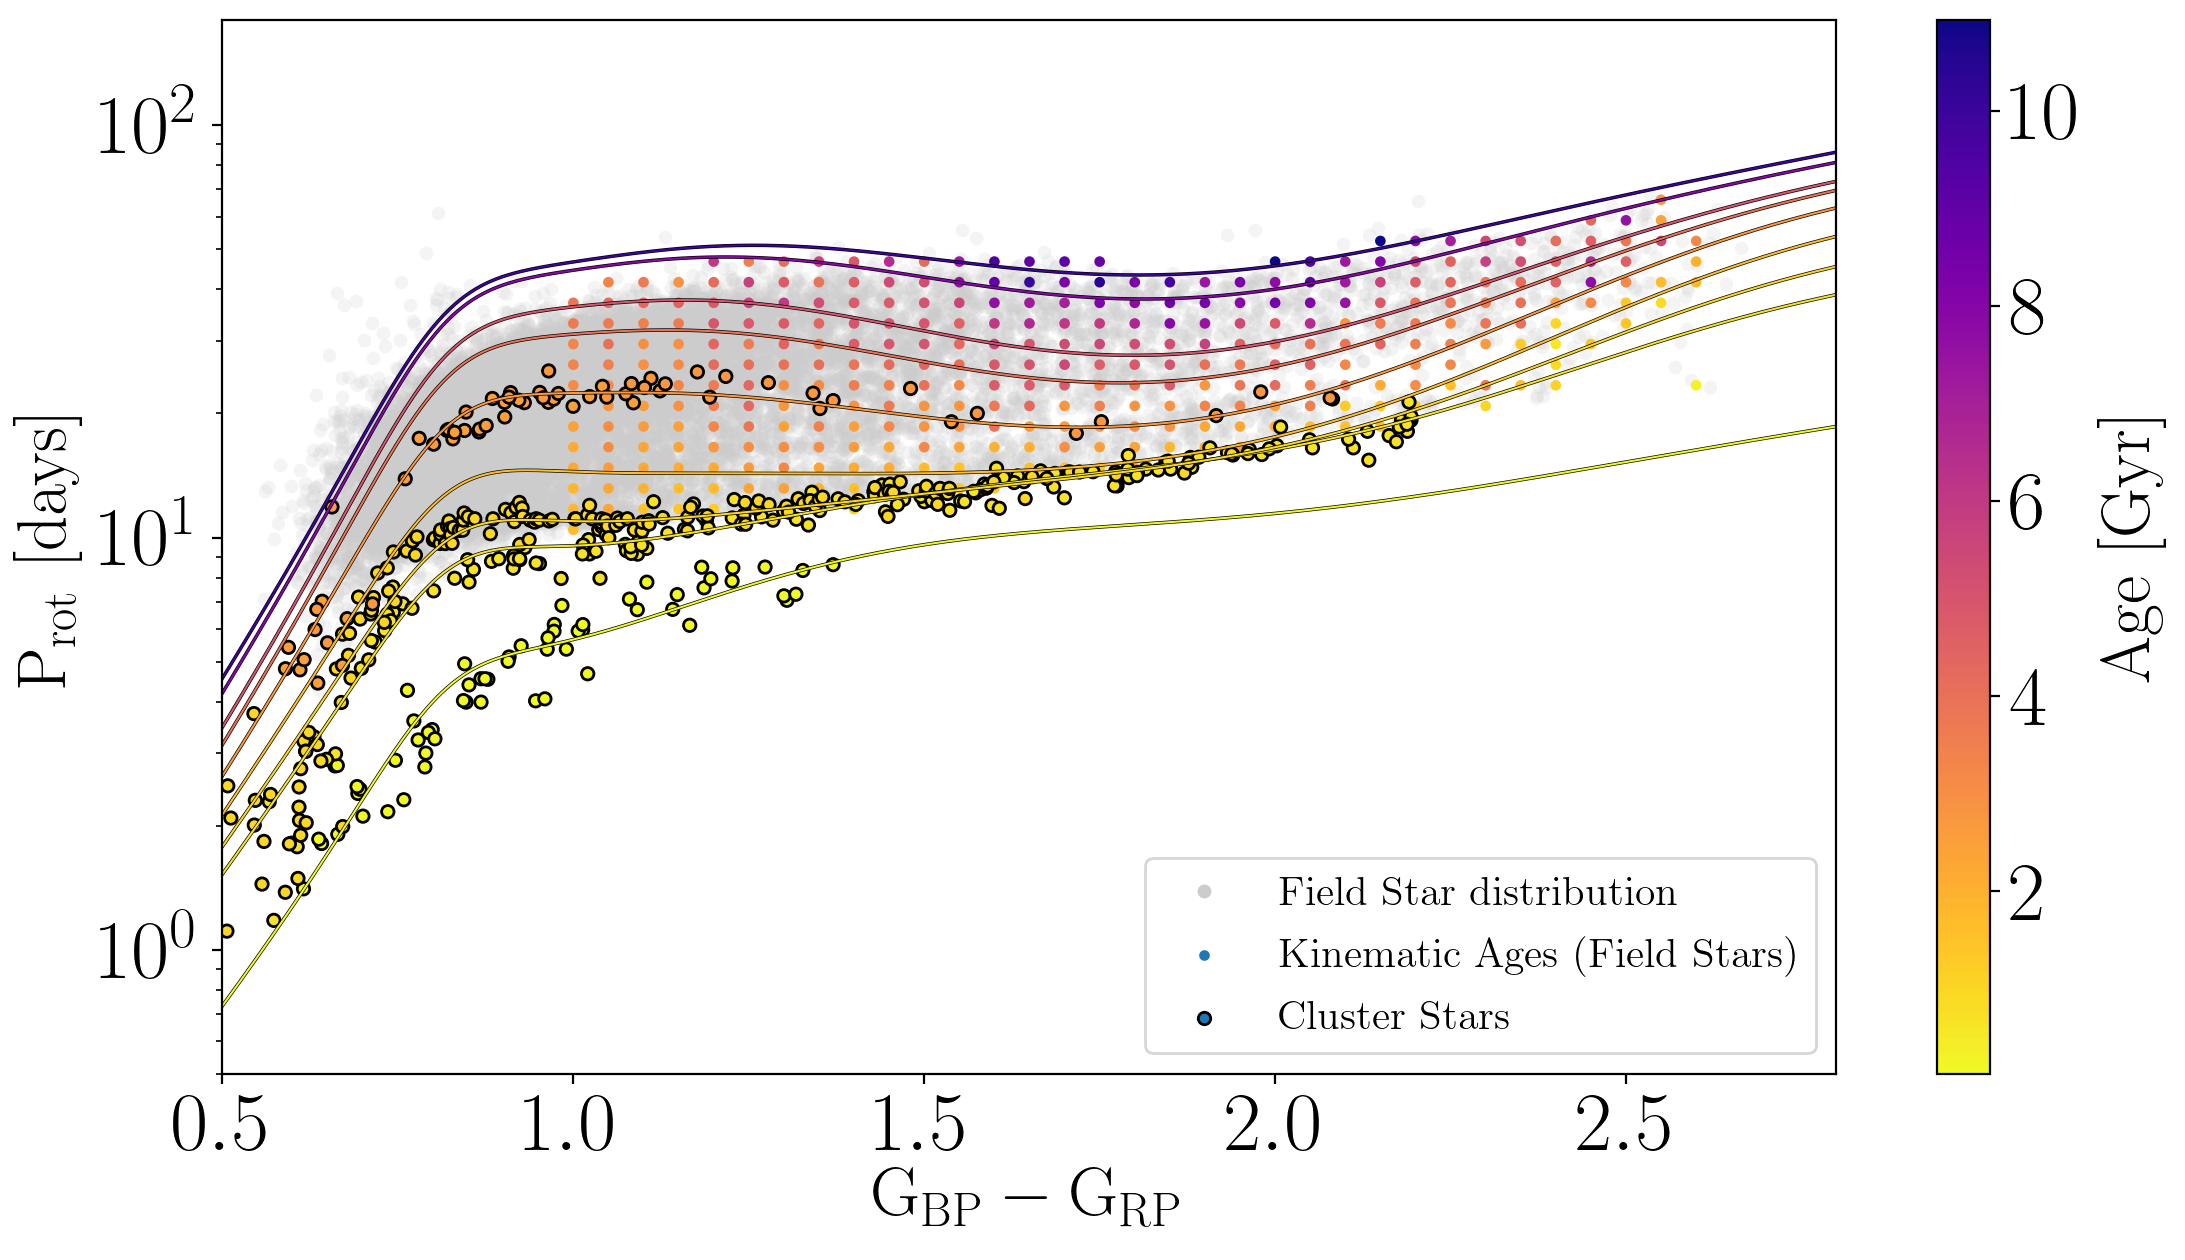

In [30]:
cmap = matplotlib.cm.get_cmap("plasma_r")

vmin = np.exp(x2).min()
vmax = np.exp(x2).max()

def get_color(x2):
    return cmap((np.exp(x2) - vmin) / (vmax - vmin))

plt.figure(figsize=(12, 7), dpi=200)
plt.plot(kin.bprp_dered, kin.Prot, ".", color=".8", mec="none", ms=10, alpha=.2, zorder=0, label="$\mathrm{Field~Star~distribution}$")
plt.scatter(x1, np.exp(y), c=np.exp(x2), vmin=vmin, vmax=vmax, s=8, cmap="plasma_r", label="$\mathrm{Kinematic~Ages~(Field~Stars)}$")
plt.scatter(cluster_x, cluster_prot, c=cluster_age, vmin=vmin, vmax=vmax, s=20, edgecolor="k", cmap="plasma_r",
            label="$\mathrm{Cluster~Stars}$")

for i in range(len(xg2)):
    plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color="k", lw=1.25)
    plt.plot(xp1, np.exp(map_soln["pred_{0}".format(i)]), color=get_color(xg2[i]), lw=0.75)

plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{P_{rot}~[days]}$")
plt.ylim(0.5, 180)
plt.yscale("log")
plt.colorbar(label="$\mathrm{Age~[Gyr]}$");
plt.xlim(.5, 2.8)
leg = plt.legend()
leg.legendHandles[0]._legmarker.set_alpha(1)
plt.tight_layout()
# plt.savefig("../plots/gp_fit.pdf")
# plt.savefig("../plots/gp_fit")

In [ ]:
# with model:
#     trace = pm.sample(1000)